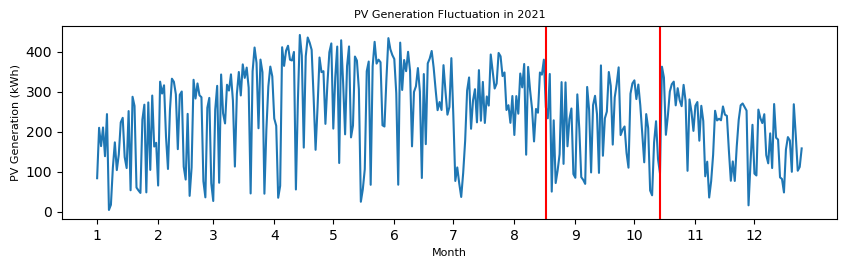

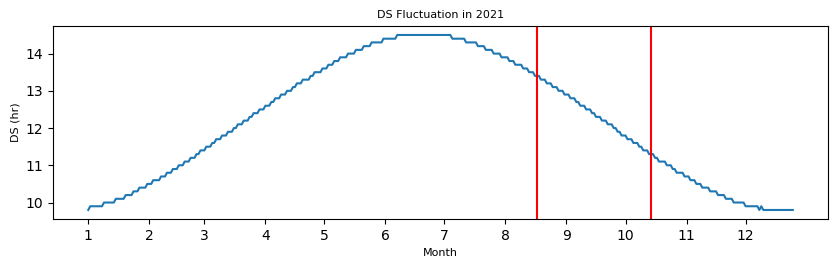

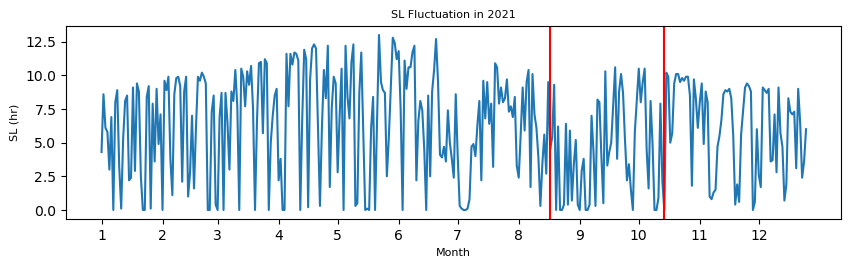

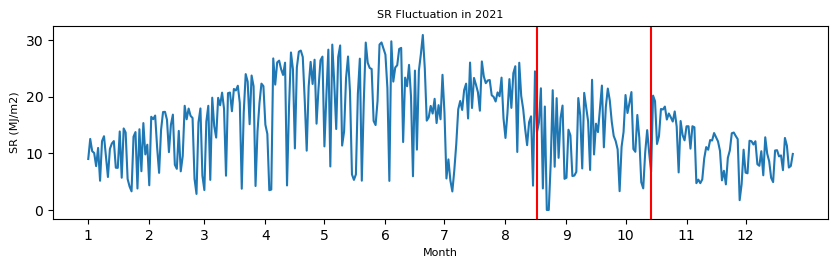

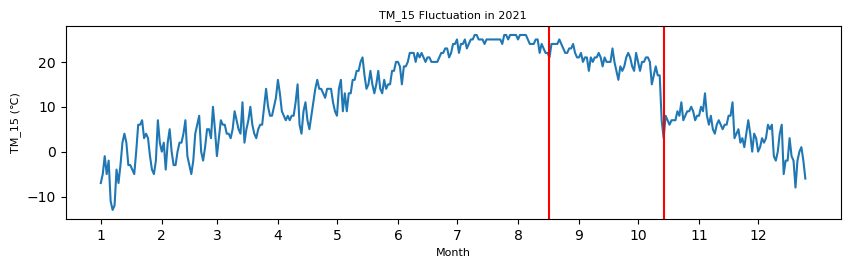

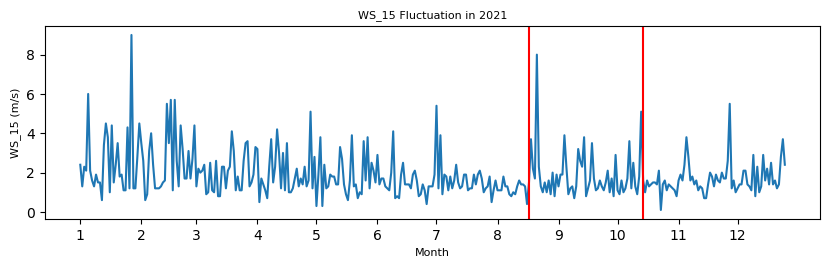

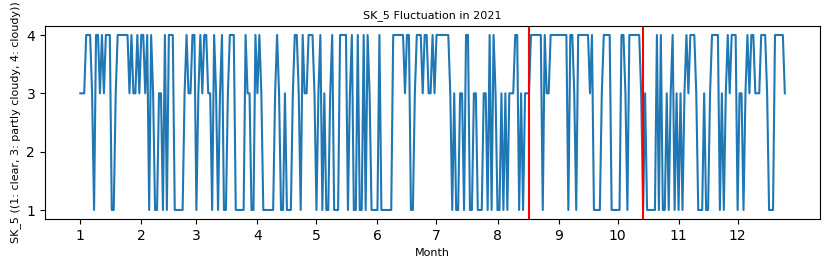

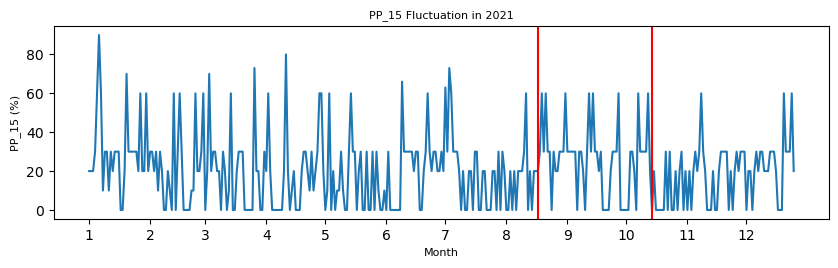

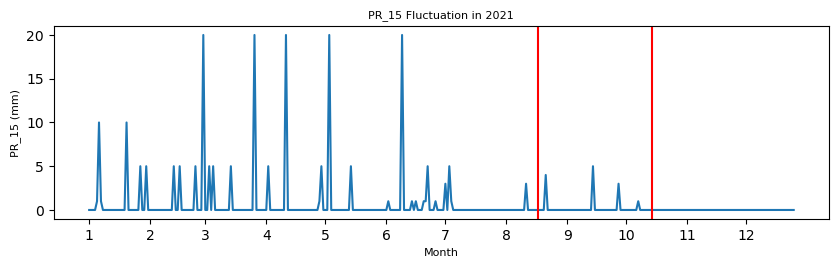

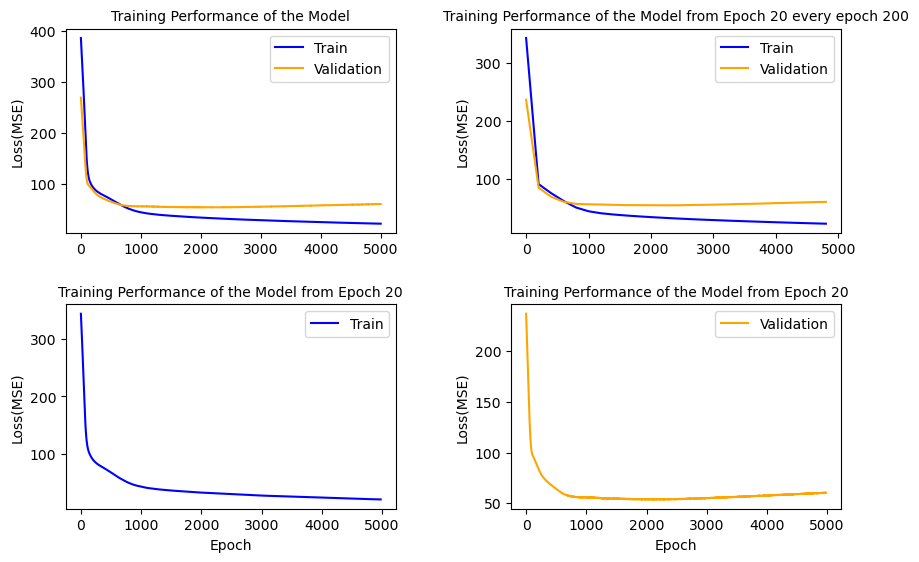

In [75]:
# Need two additional arguments: case, num_of_features, basic_path
# ex.
# python pv_forecast_model_almost_everyday.py 1 50 "./processed_data/pv/2021_weather_and_RISEPV.csv"
# python pv_forecast_model_almost_everyday.py 1 52 "./processed_data/pv_forecastweather_feature.csv.csv"


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime, sys, os
import Dataset_Class as DC


# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023
EPOCHS = 5000
LEARNING_RATE = 0.00001
# LR is modified: 0.0001 -> 0.00001



class Net(nn.Module):
    def __init__(self, num_of_features, **model_config):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_of_features, 64)
        self.model_type = model_config['case']
        if model_config['case'] == 1 or model_config['case'] == 2:
            self.hidden_dim = 512
        elif model_config['case'] == 3 or model_config['case'] == 4:
            self.hidden_dim = 1024
        self.fc2 = nn.Linear(64, self.hidden_dim)
        self.fc3 = nn.Linear(self.hidden_dim, 24)
        self.relu = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(self.hidden_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        model_type = self.model_type
        if model_type == 1 or model_type == 3:
            pass
        elif model_type == 2 or model_type == 4:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.fc2(x)
        if model_type == 1 or model_type == 3:
            pass
        elif model_type == 2 or model_type == 4:
            x = self.batch_norm2(x)
        x = self.relu(x)
        output = self.fc3(x)
        return output
    

# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


# load the data and split into X and Y
def load_data(path, num_of_features):
    load = pd.read_csv(path, index_col = 0).iloc[:,0:num_of_features]
    num_of_days = len(load)
    col = load.columns
    X = load.iloc[0:num_of_days-1,:]
    Y = load.iloc[1:num_of_days,0:24]
    X = torch.FloatTensor(X.values)
    Y = torch.FloatTensor(Y.values)
    return X, Y, col


# split data into mini_train, valid, train, test
def split_data(X, Y, batch_size, data_len, train_pie, mini_train_pie):
    train_size = int(data_len * train_pie)
    mini_train_size = int(train_size * mini_train_pie)
    
    train_data = DC.CustomDataset(X[:train_size], Y[:train_size])
    test_data = DC.CustomDataset(X[train_size:], Y[train_size:])
    mini_train_data = DC.CustomDataset(X[:mini_train_size], Y[:mini_train_size])
    valid_data = DC.CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])
    mini_train_dataloader = DataLoader(mini_train_data, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(valid_data, batch_size = len(valid_data), shuffle = False)
    train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_data, batch_size = len(test_data), shuffle = False)
    
    return mini_train_dataloader, valid_dataloader, train_dataloader, test_dataloader, mini_train_size, train_size


# create folder if not exist
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)


# plot daily feature graphs
def plot_daily_feature(X, label_interval, col_list, fig_size, font_size, mini_train_point, valid_point, pre_save_path):
    unit=''
    for i in range(len(col_list)):
        if i == 0:
            # 0~23th columns: pv generation of 24 hours
            data = torch.sum(X[:,0:24], axis=1).detach().numpy().reshape(-1)
            col = 'PV Generation'
            unit = 'kWh'
        elif i == 24:
            # 24th column: duration of sunshine
            data = X[:,i]
            col = col_list[i]
            unit = 'hr'
        elif i == 25:
            # 25th column: sunlight
            data = X[:,i]
            col = col_list[i]
            unit = 'hr'
        elif i == 26:
            # 26th column: solar radiation
            data = X[:,i]
            col = col_list[i]
            unit = 'MJ/m2'
        elif i == 30:
            # 30th column: temperature of 15h on next day
            data = X[:,i]
            col = col_list[i]
            unit = '℃'
        elif i == 35:
            # 35th column: wind speed of 15h on next day
            data = X[:,i]
            col = col_list[i]
            unit = 'm/s'
        elif i == 40:
            # 40th column: state of sky of 15h on next day
            data = X[:,i]
            col = col_list[i]
            unit = '(1: clear, 3: partly cloudy, 4: cloudy)'
        elif i == 45:
            # 45th column: probability of precipitation of 15h on next day
            data = X[:,i]
            col = col_list[i]
            unit = '%'
        elif i == 48:
            # 48th column: precipitation of 15h on next day
            data = X[:,i]
            col = col_list[i]
            unit = 'mm'
        else:
            continue

        # Create figure and plot the data
        fig = plt.figure(figsize=fig_size)
        ax = plt.axes()
        ax.plot(data)

        plt.title(col+" Fluctuation in 2021", fontsize = font_size)
        plt.xlabel('Month', fontsize = font_size)
        plt.ylabel(col+' ('+unit+')', fontsize = font_size)

        # Set the x-tick positions and labels
        x_ticks = []
        x_labels = []
        for i, interval in enumerate(label_interval):
            start = sum(label_interval[:i])            # X를 그대로 사용하지 않고, 일자별로 load 합계를 구했기 때문에 feature 개수인 24를 곱하지 않는다.
            x_ticks.append(start)
            x_labels.append(f'{i+1}')

        plt.axvline(x = mini_train_point, c='r')
        plt.axvline(x = valid_point, c='r')
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        
        # save the figure
        plt.savefig(pre_save_path+col+'.png')


def plot_loss(mini_train_loss_arr, val_loss_arr, range_start, fig_size, title, font_size, save_path):
    fig = plt.figure(figsize=fig_size)
    
    plt.subplot(221)
    plt.title(title, fontsize = font_size)
    # plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(mini_train_loss_arr, c = 'blue', label = 'Train')
    plt.plot(val_loss_arr, c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(222)
    plt.title(title+' from Epoch '+str(range_start)+' every epoch 200', fontsize = font_size)
    # plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(np.arange(0, 5000, 200),mini_train_loss_arr[range_start::200], c = 'blue', label = 'Train')
    plt.plot(np.arange(0, 5000, 200),val_loss_arr[range_start::200], c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(223)
    plt.title(title+' from Epoch '+str(range_start), fontsize = font_size)
    plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(mini_train_loss_arr[range_start:], c = 'blue', label = 'Train')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(224)
    plt.title(title+' from Epoch '+str(range_start), fontsize = font_size)
    plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(val_loss_arr[range_start:], c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)
    
    # save the figure
    plt.savefig(save_path)

    
def plot(i, length, output, Y, fig_size, title, font_size, save_path):
    fig = plt.figure(figsize=fig_size)
    plt.title(title, fontsize = font_size)
    plt.xlabel('Time (h)', fontsize = font_size)
    plt.ylabel('Load', fontsize = font_size)
    plt.plot(Y.detach().numpy()[i:i+length,:].reshape(-1), c='blue', label = 'Actual data')
    plt.plot(output.detach().numpy()[i:i+length,:].reshape(-1), c='red', label = 'forecast data')
    plt.legend(loc='lower right', fontsize = 13)
    plt.savefig(save_path)

     
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(train_dataloader.dataset)/24).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y


set_seed(RANDOM_SEED)
model_case = 1
num_of_features = 50
basic_path = "./processed_data/pv/2021_weather_and_RISEPV.csv"
mae = nn.L1Loss()
mape = MAPE()


# data loading
# X: 210101-211230, Y: 210102-211231 / 360*50  (210618, 210930, 211222~211224 missing)
# X: 210104-211229, Y: 210105-211230 / 234x52
X, Y, col_list = load_data(basic_path, num_of_features)
dataset = DC.CustomDataset(X, Y)
data_len = len(dataset)
mini_train_dataloader, valid_dataloader, train_dataloader, test_dataloader, mini_train_size, train_size =  split_data(X, Y, 32, data_len, 0.8, 0.8)
# 229개   210101 ~ 210818
# 58개    210819 ~ 211016
# 287개   210101 ~ 211016
# 73개    211017 ~ 211230
# --------------------------------------------------
# 148개   210104 ~ 210819
# 38개    210820 ~ 211015
# 186개   210104 ~ 211015
# 47개    211018 ~ 211229


# load plotting
dir = './experiment_outputs/pv_forecast/'
now = datetime.datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
if basic_path == "./processed_data/pv/2021_weather_and_RISEPV.csv":
    file = 'everyday'
    label_interval = [31,28,31,30,31,30,31,31,30,31,30,28]
elif basic_path == "./processed_data/pv_forecastweather_feature.csv.csv":
    # TODO: loading 하는 파일 feature 배열 수정해야 함
    file = 'week'
    label_interval = [18, 17, 22, 21, 19, 15, 22, 21, 21, 19, 21, 18]
    
file_name = f'{model_case}_{num_of_features}_{file}_{timestamp}'
_path = dir+"plots/daily_pv_features/"+file_name
create_folder(_path)
plot_daily_feature(X, label_interval, col_list, (10,2.5), 8, mini_train_size-1, train_size-1, _path+'/')


# model setting
model_config = {'case': model_case}
model = Net(num_of_features, **model_config).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
criterion2 = nn.MSELoss(reduction = 'mean').to(DEVICE)


# file to save the results
f = open(dir+f"results/{file_name}.txt", 'w')


# model training and validation
mini_train_loss_arr = []
val_loss_arr = []

best_val_loss = float('inf')
best_val_epoch = 0

for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion2(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
    if epoch % 500 == 0:
        # write a log on file
        print(f'Train Epoch: {epoch:4d}/{EPOCHS}  |  Train Loss {mini_train_loss:.6f}  |  Val Loss {val_loss:.6f}', file = f)
        
print('-'*80, file = f)
print(f'The Best Epoch: {best_val_epoch}  |  The Best Validation Error: {best_val_loss:.6f}', file = f)
print('-'*80, file = f)
print('-'*80, file = f)

plot_loss(mini_train_loss_arr, val_loss_arr, range_start=20, fig_size=(10,6), title = 'Training Performance of the Model', font_size = 10, save_path = dir+f'plots/loss/{file_name}.png')





In [79]:

# training and testing
set_seed(RANDOM_SEED)

for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 500 == 0:
        print(f'Train Epoch: {epoch:4d}/{best_val_epoch}  |  Train Loss {train_loss:.6f}', file = f)

In [87]:
test_output, test_y = evaluate(model, test_dataloader)
test_output = torch.where(test_output > 0, test_output, 0)  
test_output[:,0:6] = 0
test_output[:, 21:] = 0


test_mse = criterion2(test_output[:, 0:24], test_y[:, 0:24])
test_mae = mae(test_output[:, 0:24], test_y[:, 0:24])

In [97]:
d3_tensor = torch.stack([test_output[:, 0:24], test_y[:, 0:24]], dim=2)

In [101]:
d3_tensor

tensor(0.)

In [109]:
test_y_nonzero_mask = torch.nonzero(test_y)

# use the masks to select only the non-zero values from the arrays
test_output_y_nonzero = test_output[test_y_nonzero_mask[:, 0], test_y_nonzero_mask[:, 1]]
test_y_nonzero = test_y[test_y_nonzero_mask[:, 0], test_y_nonzero_mask[:, 1]]

# calculate the MAPE
test_mape = torch.mean(torch.abs((test_output_y_nonzero - test_y_nonzero) / test_y_nonzero))


In [120]:
print(test_output[:, 5:10])

tensor([[ 0.0000,  0.3544,  1.9775,  9.2480, 23.3380],
        [ 0.0000,  0.0000,  1.3563,  8.0830, 16.0061],
        [ 0.0000,  0.0568,  0.0000,  4.3399, 10.5357],
        [ 0.0000,  0.0000,  0.6114,  2.9441,  7.1895],
        [ 0.0000,  0.0802,  2.3479,  9.7539, 20.8470],
        [ 0.0000,  0.0000,  1.9361,  8.9177, 19.9626],
        [ 0.0000,  0.2723,  1.4276,  7.2736, 18.9801],
        [ 0.0000,  0.0000,  2.4837,  7.6379, 19.9080],
        [ 0.0000,  0.1481,  1.2487,  8.3450, 22.4614],
        [ 0.0000,  0.2048,  1.5285,  7.1562, 17.3606],
        [ 0.0000,  0.0000,  0.4036,  6.7167, 14.5575],
        [ 0.0000,  0.4158,  1.2473, 10.0389, 24.1274],
        [ 0.0000,  0.0000,  0.1261,  5.2546, 12.9223],
        [ 0.0000,  0.0687,  2.9264,  7.0858, 20.5344],
        [ 0.0000,  0.0651,  0.4121,  5.2445, 15.7204],
        [ 0.0000,  0.0000,  0.5059,  4.7116, 15.5328],
        [ 0.0000,  0.0000,  0.4669,  4.1909, 17.2454],
        [ 0.0000,  0.1913,  1.6802,  7.4259, 17.8459],
        [ 

In [116]:
print(test_output_y_nonzero)

tensor([ 1.9775,  9.2480, 23.3380, 32.4591, 41.4859, 46.9226, 47.6880, 40.8391,
        36.5193, 24.7876, 15.3046,  1.3563,  8.0830, 16.0061, 22.2991, 26.4374,
        21.5162, 23.1861, 21.8582, 24.0896, 24.7433, 14.7095,  0.0000,  4.3399,
        10.5357, 20.8892, 34.1993, 36.3421, 41.6109, 34.0148, 26.8629, 26.4199,
        13.5494,  0.6114,  2.9441,  7.1895, 13.9008, 21.7287, 20.2579, 14.4358,
        11.4360, 20.3172, 13.4721,  6.0247,  2.3479,  9.7539, 20.8470, 29.4113,
        37.5020, 40.1894, 41.3861, 36.7028, 34.5080, 29.0827, 17.5492,  1.9361,
         8.9177, 19.9626, 30.5047, 37.7129, 38.1876, 37.7650, 32.0683, 31.5959,
        26.2379, 13.9862,  1.4276,  7.2736, 18.9801, 24.2037, 30.9316, 31.9818,
        31.7150, 24.5826, 20.8987, 14.2134,  9.0592,  2.4837,  7.6379, 19.9080,
        34.0070, 32.0543, 37.2209, 34.0046, 41.4306, 29.1574, 26.0783, 12.4816,
         1.2487,  8.3450, 22.4614, 31.4173, 41.4840, 44.5970, 41.2381, 39.3696,
        32.3632, 21.0881, 13.3318,  1.52

In [104]:
test_y_nonzero_mask

tensor([[ 0,  7],
        [ 0,  8],
        [ 0,  9],
        ...,
        [71, 15],
        [71, 16],
        [71, 17]])

In [76]:

# calculate MAPE for values >0
# select only values>0 from test_output and test_y
test_output = test_output[:, 0:24]
test_y = test_y[:, 0:24]
test_output = test_output[test_y>0]
test_y = test_y[test_y>0]    
    
test_mape = mape(test_output[:, 0:24], test_y[:, 0:24])

print('Test Loss', file = f)
print('MSE: {:.6f}'.format(test_mse), file = f)
print('MAE: {:.6f}'.format(test_mae), file = f)
print('MAPE(%): {:.6f}'.format(test_mape*100), file = f)



plot(1, 20, test_output[:, 0:24], test_y[:, 0:24], (20, 5), 'Actual and forecast PV for 20 days', 18, dir+f'plots/forecasted_pv/{file_name}.png')



f.close()

torch.save(model.state_dict(), dir+f'models/{file_name}.pt')

IndexError: too many indices for tensor of dimension 1